# GeoGlim Package - Usage Example

This notebook demonstrates how to use the GeoGlim package for geological data processing and spatial clipping.

## 📋 Prerequisites

Before running this notebook, make sure:
1. The GeoGlim API server is running: `python -m uvicorn backend.main:app --host 0.0.0.0 --port 8000 --reload`
2. All required packages are installed: `geopandas`, `requests`, `shapely`, `matplotlib`

## 🌍 Available Datasets

- **GLiM**: Global Lithological Map (1.2M+ features)
- **GLHYMPS**: Global Hydrogeology and Porosity (1.8M+ features)

In [1]:
# Import required libraries
import requests
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import box, Point
import tempfile
import os
import json
from pathlib import Path

# Set up plotting
plt.style.use('default')
%matplotlib inline

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 1. 🔍 Check API Health and Dataset Availability

In [2]:
# Check if the GeoGlim API is running
API_BASE_URL = "http://localhost:8000"

try:
    response = requests.get(f"{API_BASE_URL}/")
    if response.status_code == 200:
        health_data = response.json()
        print("🎉 GeoGlim API is running!")
        print(f"📊 API Status: {health_data['status']}")
        print(f"🏷️  API Version: {health_data['api_version']}")
        print(f"🏠 Hosting: {health_data['hosting']}")
        print("\n📚 Available Datasets:")
        
        for dataset, available in health_data['datasets_available'].items():
            status = "✅ Available" if available else "❌ Not Available"
            print(f"  - {dataset.upper()}: {status}")
            
        # Store dataset availability for later use
        datasets_available = health_data['datasets_available']
    else:
        print(f"❌ API not responding properly: {response.status_code}")
except Exception as e:
    print(f"❌ Error connecting to API: {e}")
    print("\n🔧 Make sure the API server is running:")
    print("   python -m uvicorn backend.main:app --host 0.0.0.0 --port 8000 --reload")

🎉 GeoGlim API is running!
📊 API Status: healthy
🏷️  API Version: 1.0.0-local
🏠 Hosting: local

📚 Available Datasets:
  - GLIM: ✅ Available
  - GLHYMPS: ✅ Available


## 2. 📊 Get Dataset Information

In [3]:
# Function to get dataset information
def get_dataset_info(dataset_name):
    """Get detailed information about a dataset"""
    try:
        response = requests.get(f"{API_BASE_URL}/datasets/{dataset_name}/info")
        if response.status_code == 200:
            return response.json()
        else:
            print(f"❌ Failed to get {dataset_name} info: {response.status_code}")
            return None
    except Exception as e:
        print(f"❌ Error getting {dataset_name} info: {e}")
        return None

# Get information for available datasets
dataset_info = {}

for dataset in ['glim', 'glhymps']:
    if datasets_available.get(dataset, False):
        print(f"\n🔍 Getting {dataset.upper()} dataset information...")
        info = get_dataset_info(dataset)
        if info:
            dataset_info[dataset] = info
            print(f"✅ {dataset.upper()} Dataset Info:")
            print(f"   📁 Path: {info['path']}")
            print(f"   🗺️  CRS: {info['crs'][:50]}...")
            print(f"   📐 Geometry Type: {info['geometry_type']}")
            print(f"   📋 Columns: {', '.join(info['columns'][:5])}...")
            print(f"   🔢 Sample Features: {info['sample_feature_count']}")
        else:
            print(f"❌ Could not retrieve {dataset.upper()} information")
    else:
        print(f"⚠️  {dataset.upper()} dataset not available")


🔍 Getting GLIM dataset information...
✅ GLIM Dataset Info:
   📁 Path: /Users/mgalib/Library/CloudStorage/Box-Box/Obsidian/Glim_Glhymps_package/GeoGlimDev/GeoGlim/backend/data/LiMW_GIS_2015.gdb/LiMW_GIS 2015.gdb
   🗺️  CRS: PROJCS["World_Eckert_IV",GEOGCS["WGS 84",DATUM["WG...
   📐 Geometry Type: MultiPolygon
   📋 Columns: IDENTITY_, Litho, xx, Shape_Length, Shape_Area...
   🔢 Sample Features: 5

🔍 Getting GLHYMPS dataset information...
✅ GLHYMPS Dataset Info:
   📁 Path: /Users/mgalib/Library/CloudStorage/Box-Box/Obsidian/Glim_Glhymps_package/GeoGlimDev/GeoGlim/backend/data/GLHYMPS/GLHYMPS.shp
   🗺️  CRS: PROJCS["Cylindrical_Equal_Area",GEOGCS["WGS 84",DA...
   📐 Geometry Type: Polygon
   📋 Columns: OBJECTID_1, IDENTITY_, logK_Ice_x, logK_Ferr_, Porosity_x...
   🔢 Sample Features: 5


## 3. 🗺️ Create Area of Interest (AOI)

🗺️ Created Area of Interest (AOI):
Name: Central Europe Test
Bounds: (12.0, 48.0, 13.0, 49.0)


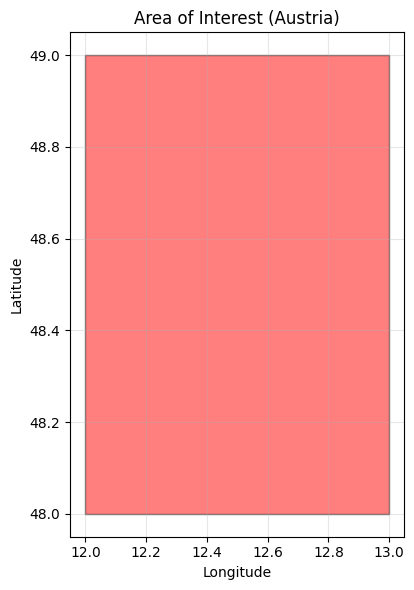

✅ AOI created and visualized!


In [4]:
# Create a small test area in Central Europe (good for testing)
small_aoi = gpd.GeoDataFrame(
    {"name": ["Central Europe Test"], "area_type": ["small_test"]},
    geometry=[box(12.0, 48.0, 13.0, 49.0)],  # 1x1 degree area in Austria
    crs="EPSG:4326"
)

print("🗺️ Created Area of Interest (AOI):")
print(f"Name: {small_aoi.iloc[0]['name']}")
print(f"Bounds: {small_aoi.geometry.iloc[0].bounds}")

# Plot the AOI
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
small_aoi.plot(ax=ax, color='red', alpha=0.5, edgecolor='black')
ax.set_title('Area of Interest (Austria)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✅ AOI created and visualized!")

## 4. 🔧 Dataset Clipping Function

In [7]:
def clip_dataset(dataset_name, aoi_gdf, output_format='geojson', timeout=300):
    """
    Clip a dataset using the GeoGlim API
    
    Parameters:
    - dataset_name: 'glim' or 'glhymps'
    - aoi_gdf: GeoDataFrame with area of interest
    - output_format: 'geojson', 'shapefile', or 'gpkg'
    - timeout: Request timeout in seconds
    
    Returns:
    - GeoDataFrame with clipped results or None if failed
    """
    
    # Save AOI to temporary file
    with tempfile.NamedTemporaryFile(mode='w', suffix='.geojson', delete=False) as f:
        aoi_gdf.to_file(f.name, driver='GeoJSON')
        geojson_path = f.name
    
    try:
        print(f"🔄 Clipping {dataset_name.upper()} dataset...")
        print(f"   AOI: {aoi_gdf.iloc[0]['name']}")
        print(f"   Format: {output_format}")
        
        # Make the clipping request
        with open(geojson_path, 'rb') as f:
            files = {'geojson_file': (f'aoi_{dataset_name}.geojson', f, 'application/json')}
            params = {'output_format': output_format}
            
            response = requests.post(
                f"{API_BASE_URL}/clip/{dataset_name}",
                files=files,
                params=params,
                timeout=timeout
            )
        
        if response.status_code == 200:
            # Save the result to a temporary file
            output_path = f"{dataset_name}_clipped.{output_format}"
            with open(output_path, 'wb') as out_file:
                out_file.write(response.content)
            
            # Read the result back as GeoDataFrame
            result_gdf = gpd.read_file(output_path)
            
            # Get feature count from response headers if available
            feature_count = response.headers.get('X-Feature-Count', len(result_gdf))
            
            print(f"✅ {dataset_name.upper()} clipping successful!")
            print(f"   Features returned: {feature_count}")
            print(f"   Output saved to: {output_path}")
            
            # Clean up temporary output file
            os.unlink(output_path)
            
            return result_gdf
            
        else:
            print(f"❌ {dataset_name.upper()} clipping failed: {response.status_code}")
            if response.text:
                print(f"   Error: {response.text[:200]}...")
            return None
            
    except requests.exceptions.Timeout:
        print(f"⏰ {dataset_name.upper()} clipping timed out after {timeout} seconds")
        print("   Try with a smaller area or increase timeout")
        return None
    except Exception as e:
        print(f"❌ Error during {dataset_name.upper()} clipping: {e}")
        return None
    finally:
        # Clean up temporary AOI file
        if os.path.exists(geojson_path):
            os.unlink(geojson_path)

print("✅ Clipping function defined!")

✅ Clipping function defined!


## 5. 🧪 Test GLiM Dataset Clipping

In [9]:
# Test clipping with GLiM dataset
print("🧪 Testing GLiM dataset clipping...")
print("=" * 50)

if datasets_available.get('glim', False):
    print("\n🌍 Testing GLiM (Global Lithological Map) clipping...")
    glim_result = clip_dataset('glim', small_aoi, output_format='geojson', timeout=300)
    
    if glim_result is not None:
        print(f"\n📊 GLiM Results Summary:")
        print(f"   Total features: {len(glim_result)}")
        print(f"   Columns: {list(glim_result.columns)}")
        print(f"   CRS: {glim_result.crs}")
        
        # Show lithology information if available
        if 'Litho' in glim_result.columns:
            unique_litho = glim_result['Litho'].unique()
            print(f"   Unique lithologies: {len(unique_litho)}")
            print(f"   Sample lithologies: {list(unique_litho[:5])}")
        
        # Store result for visualization
        glim_clipped = glim_result
    else:
        print("⚠️  GLiM clipping failed or timed out")
        glim_clipped = None
else:
    print("⚠️  GLiM dataset not available")
    glim_clipped = None

print("\n" + "=" * 50)
print("🎯 GLiM clipping test completed!")

🧪 Testing GLiM dataset clipping...

🌍 Testing GLiM (Global Lithological Map) clipping...
🔄 Clipping GLIM dataset...
   AOI: Central Europe Test
   Format: geojson
✅ GLIM clipping successful!
   Features returned: 314
   Output saved to: glim_clipped.geojson

📊 GLiM Results Summary:
   Total features: 314
   Columns: ['IDENTITY_', 'Litho', 'xx', 'Shape_Length', 'Shape_Area', 'name', 'area_type', 'geometry']
   CRS: PROJCS["World_Eckert_IV",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Eckert_IV"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["ESRI","54012"]]
   Unique lithologies: 13
   Sample lithologies: ['scmx__', 'mt____', 'pa____', 'sumx__', 'suss__']

🎯 GLiM clipping test completed!


## 6. 📊 Visualize Results

🎨 Visualizing GLiM clipping results...


/var/folders/ns/7gh688vn04x1rtn_tsr23pmm0000gn/T/ipykernel_80954/226640196.py:14: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  axes[0].legend()
/var/folders/ns/7gh688vn04x1rtn_tsr23pmm0000gn/T/ipykernel_80954/226640196.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()


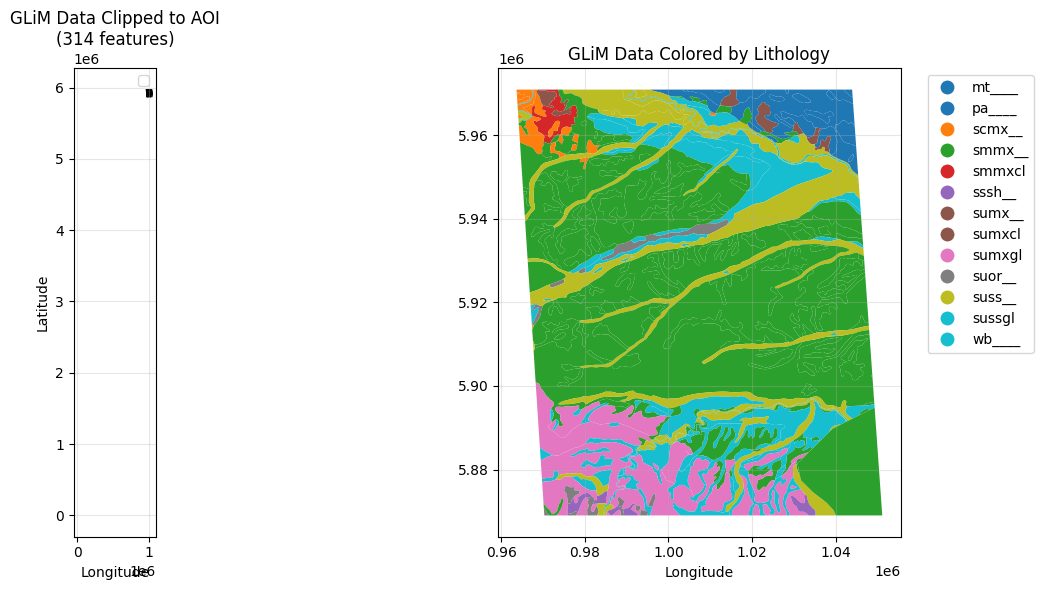


📋 GLiM Data Summary:
  IDENTITY_   Litho  xx  Shape_Length    Shape_Area                 name  \
0  DEU13917  scmx__  sc  2.278154e+06  4.286903e+09  Central Europe Test   
1  DEU16441  mt____  mt  3.460856e+04  1.338286e+07  Central Europe Test   
2  DEU16615  mt____  mt  5.472479e+04  3.805777e+07  Central Europe Test   
3  DEU16644  pa____  pa  1.396510e+05  1.814787e+08  Central Europe Test   
4  DEU16657  sumx__  su  2.114350e+04  1.718547e+07  Central Europe Test   

    area_type                                           geometry  
0  small_test  MULTIPOLYGON (((967075.206 5970848.52, 967118....  
1  small_test  POLYGON ((1028730.754 5970813.123, 1028748.144...  
2  small_test  POLYGON ((1041973.792 5970847.546, 1041998.687...  
3  small_test  POLYGON ((1044019.137 5969046.89, 1043892.035 ...  
4  small_test  POLYGON ((1016848.513 5967602.12, 1016673.665 ...  

🪨 Lithology Distribution:
Litho
smmx__    113
sussgl     76
suss__     33
sumxgl     23
scmx__     14
mt____     13
su

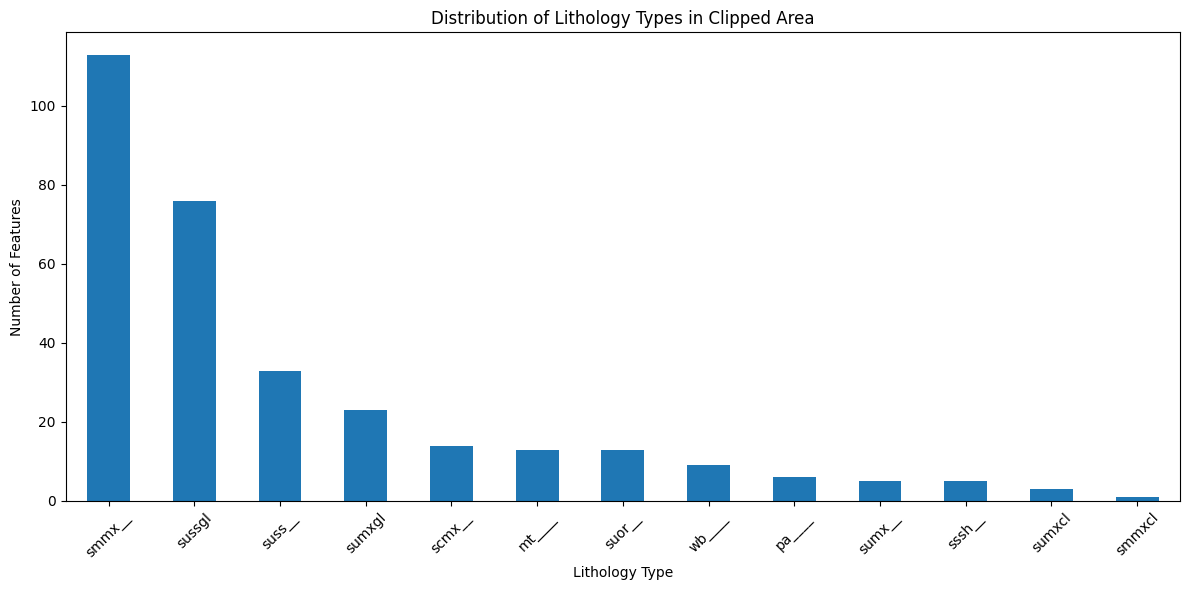

In [10]:
# Visualize the clipping results
if glim_clipped is not None:
    print("🎨 Visualizing GLiM clipping results...")
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: AOI and clipped data
    small_aoi.plot(ax=axes[0], color='red', alpha=0.3, edgecolor='red', linewidth=2, label='AOI')
    glim_clipped.plot(ax=axes[0], alpha=0.7, edgecolor='black', linewidth=0.5, label='GLiM Data')
    axes[0].set_title(f'GLiM Data Clipped to AOI\n({len(glim_clipped)} features)')
    axes[0].set_xlabel('Longitude')
    axes[0].set_ylabel('Latitude')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Lithology types (if available)
    if 'Litho' in glim_clipped.columns:
        # Color by lithology
        glim_clipped.plot(column='Litho', ax=axes[1], legend=True, 
                         legend_kwds={'bbox_to_anchor': (1.05, 1), 'loc': 'upper left'})
        axes[1].set_title('GLiM Data Colored by Lithology')
    else:
        glim_clipped.plot(ax=axes[1], alpha=0.7, edgecolor='black', linewidth=0.5)
        axes[1].set_title('GLiM Data (No Lithology Column)')
    
    axes[1].set_xlabel('Longitude')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Show data summary
    print("\n📋 GLiM Data Summary:")
    print(glim_clipped.head())
    
    if 'Litho' in glim_clipped.columns:
        print("\n🪨 Lithology Distribution:")
        litho_counts = glim_clipped['Litho'].value_counts()
        print(litho_counts)
        
        # Plot lithology distribution
        plt.figure(figsize=(12, 6))
        litho_counts.plot(kind='bar')
        plt.title('Distribution of Lithology Types in Clipped Area')
        plt.xlabel('Lithology Type')
        plt.ylabel('Number of Features')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

else:
    print("⚠️  No GLiM data to visualize (clipping may have failed or timed out)")
    print("💡 Try running the clipping test again or use a smaller AOI")

## 7. 💾 Save Results

In [ ]:
# Save results to files
output_dir = Path("geoglim_results")
output_dir.mkdir(exist_ok=True)

print(f"💾 Saving results to {output_dir}/...")

if glim_clipped is not None:
    # Save GLiM results in multiple formats
    glim_geojson = output_dir / "glim_clipped.geojson"
    glim_shapefile = output_dir / "glim_clipped.shp"
    glim_gpkg = output_dir / "glim_clipped.gpkg"
    
    glim_clipped.to_file(glim_geojson, driver='GeoJSON')
    glim_clipped.to_file(glim_shapefile, driver='ESRI Shapefile')
    glim_clipped.to_file(glim_gpkg, driver='GPKG')
    
    print(f"✅ GLiM data saved:")
    print(f"   📄 GeoJSON: {glim_geojson}")
    print(f"   📄 Shapefile: {glim_shapefile}")
    print(f"   📄 GeoPackage: {glim_gpkg}")

# Save the AOI for reference
aoi_file = output_dir / "area_of_interest.geojson"
small_aoi.to_file(aoi_file, driver='GeoJSON')
print(f"✅ AOI saved: {aoi_file}")

print(f"\n📁 All results saved to: {output_dir.absolute()}")

## 8. 📈 Basic Data Analysis

In [11]:
if glim_clipped is not None:
    print("📈 Performing basic analysis on GLiM data...")
    print("=" * 50)
    
    # Basic statistics
    print(f"📊 Dataset Statistics:")
    print(f"   Total features: {len(glim_clipped)}")
    print(f"   Total area covered: {glim_clipped.geometry.area.sum():.6f} square degrees")
    print(f"   Bounding box: {glim_clipped.total_bounds}")
    
    # Geometric analysis
    if len(glim_clipped) > 0:
        areas = glim_clipped.geometry.area
        print(f"\n📐 Geometric Analysis:")
        print(f"   Largest feature area: {areas.max():.6f} square degrees")
        print(f"   Smallest feature area: {areas.min():.6f} square degrees")
        print(f"   Average feature area: {areas.mean():.6f} square degrees")
    
    print("\n✅ Analysis completed!")
else:
    print("⚠️  No data available for analysis")

📈 Performing basic analysis on GLiM data...
📊 Dataset Statistics:
   Total features: 314
   Total area covered: 8210943873.353637 square degrees
   Bounding box: [ 963650.90553843 5869016.45095323 1051163.21372311 5970912.62285522]

📐 Geometric Analysis:
   Largest feature area: 1501856094.003223 square degrees
   Smallest feature area: 589.617236 square degrees
   Average feature area: 26149502.781381 square degrees

✅ Analysis completed!


## 🎯 Summary

This notebook demonstrated:

1. **API Health Check** - Verifying the GeoGlim API is running
2. **Dataset Information** - Getting metadata about available datasets
3. **AOI Creation** - Creating areas of interest for clipping
4. **Data Clipping** - Using the API to clip geological datasets
5. **Visualization** - Plotting the results with matplotlib
6. **Data Export** - Saving results in multiple formats
7. **Basic Analysis** - Performing simple statistical analysis

### 🌍 Next Steps

- Try different AOI shapes and sizes
- Experiment with different output formats
- Combine GLiM and GLHYMPS data for comprehensive analysis
- Use the clipped data in your geological research projects

### 📚 Resources

- **GLiM Dataset**: [Global Lithological Map](https://doi.org/10.1594/GFZ.GEOFON.gfz2009cl1)
- **GLHYMPS Dataset**: [Global Hydrogeology](https://doi.org/10.1038/sdata.2017.89)
- **API Documentation**: http://localhost:8000/docs